
# CSE473s – Neural Network Library & Advanced Applications  
## Fall 2025 – project_demo.ipynb

This notebook demonstrates the complete workflow required for the Major Task:

1. **Gradient Checking** – validating correctness of backpropagation  
2. **XOR Problem** – using the custom NumPy-based neural network library  
3. **MNIST Autoencoder** – dimensionality reduction and reconstruction  
4. **Latent Space SVM Classification** – supervised learning using encoder features  
5. **TensorFlow/Keras Comparison** – industry-standard baselines  
6. **Final Conclusions**



In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt

# Add project root so we can import from lib/
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from lib.layers import Dense
from lib.activations import ReLU, Sigmoid, Tanh, Softmax
from lib.losses import MSELoss
from lib.optimizer import SGD
from lib.network import Sequential

print("Environment ready. Repo path:", repo_root)


Environment ready. Repo path: f:\COURSES\CI\CI_Project\CSE473s_NeuralNetwork_Library_Project


## Section 1 — Gradient Checking

 Before using our neural network library, we must validate that
 backpropagation is correct.

We do this by comparing:

  Analytical gradient *(from backward pass)* 
  
  Numerical gradient *using the finite difference approximation*:
     dL/dW ≈ (L(W + ε) - L(W - ε)) / (2ε)
    

 where ε is a small constant (e.g., 1e-5).

 If the relative error is very small (e.g., < 1e-4),  
 then our backprop implementation is correct.
 


In [3]:
def numerical_gradient(network, loss_fn, x, y, eps=1e-5):
    """Compute numerical gradients for all params."""
    num_grads = []
    _ = network.forward(x)
    params = network.parameters()

    for (param, grad) in params:
        num_grad = np.zeros_like(param)
        it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])

        while not it.finished:
            idx = it.multi_index
            original = param[idx]

            # f(W + eps)
            param[idx] = original + eps
            loss_plus = loss_fn.forward(network.forward(x), y)

            # f(W - eps)
            param[idx] = original - eps
            loss_minus = loss_fn.forward(network.forward(x), y)

            # Restore
            param[idx] = original

            num_grad[idx] = (loss_plus - loss_minus) / (2 * eps)
            it.iternext()

        num_grads.append(num_grad)
    return num_grads


def check_gradients():
    np.random.seed(0)

    net = Sequential([
        Dense(2, 3),
        Tanh(),
        Dense(3, 1)
    ])

    x = np.random.randn(4, 2)
    y = np.random.randn(4, 1)

    loss_fn = MSELoss()
    pred = net.forward(x)
    loss = loss_fn.forward(pred, y)

    grad_loss = loss_fn.backward()
    net.backward(grad_loss)

    numerical = numerical_gradient(net, loss_fn, x, y)
    analytical = [grad for _, grad in net.parameters()]

    print("Gradient Check Results:\n")
    for i, (ana, num) in enumerate(zip(analytical, numerical)):
        rel_err = np.linalg.norm(ana - num) / (np.linalg.norm(ana) + 1e-8)
        print(f"Param {i}: relative error = {rel_err:.6e}")

check_gradients()


Gradient Check Results:

Param 0: relative error = 5.722442e-11
Param 1: relative error = 4.967208e-11
Param 2: relative error = 1.571804e-11
Param 3: relative error = 6.136082e-12


## Section 2 — XOR Problem
 We use our custom neural network library to train a simple MLP to learn XOR.

### Network:
Input: 2  
Hidden: 4 neurons, Tanh activation  
Output: 1 neuron, Sigmoid activation  

### Goal:
  [0,0] → 0  
  [0,1] → 1  
  [1,0] → 1  
  [1,1] → 0

In [4]:
# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float64)
y = np.array([[0],[1],[1],[0]], dtype=np.float64)

xor_net = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])

loss_fn = MSELoss()
opt = SGD(xor_net.parameters(), lr=0.1)

epochs = 10000
for epoch in range(epochs):
    pred = xor_net.forward(X)
    loss = loss_fn.forward(pred, y)

    grad_loss = loss_fn.backward()
    xor_net.backward(grad_loss)

    opt.step()
    opt.zero_grad()

    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1}, Loss = {loss:.6f}")

print("\nFinal XOR Predictions:")
pred_classes = (pred > 0.5).astype(int)
pred = xor_net.forward(X)
for i in range(len(X)):
    print(f"Input {X[i]} -> class={pred_classes[i,0]}, target={y[i,0].astype(int)}")


Epoch 1000, Loss = 0.065904
Epoch 2000, Loss = 0.009780
Epoch 3000, Loss = 0.004233
Epoch 4000, Loss = 0.002552
Epoch 5000, Loss = 0.001782
Epoch 6000, Loss = 0.001350
Epoch 7000, Loss = 0.001078
Epoch 8000, Loss = 0.000892
Epoch 9000, Loss = 0.000757
Epoch 10000, Loss = 0.000656

Final XOR Predictions:
Input [0. 0.] -> class=0, target=0
Input [0. 1.] -> class=1, target=1
Input [1. 0.] -> class=1, target=1
Input [1. 1.] -> class=0, target=0


## Section 3 — MNIST Autoencoder (Custom Library)

 We build and train an autoencoder:  

 **Encoder:**  
 784 → 128 → 32   

 **Decoder:**  
 32 → 128 → 784  

 Training is unsupervised (input = target).  
 We visualize loss curve + reconstructions.


Train: (60000, 784)  Test: (10000, 784)
Epoch 1/400: Loss=0.230306
Epoch 2/400: Loss=0.225383
Epoch 3/400: Loss=0.192861
Epoch 4/400: Loss=0.093441
Epoch 5/400: Loss=0.072850
Epoch 6/400: Loss=0.071248
Epoch 7/400: Loss=0.070655
Epoch 8/400: Loss=0.070306
Epoch 9/400: Loss=0.070029
Epoch 10/400: Loss=0.069798
Epoch 11/400: Loss=0.069592
Epoch 12/400: Loss=0.069405
Epoch 13/400: Loss=0.069233
Epoch 14/400: Loss=0.069063
Epoch 15/400: Loss=0.068902
Epoch 16/400: Loss=0.068756
Epoch 17/400: Loss=0.068575
Epoch 18/400: Loss=0.068411
Epoch 19/400: Loss=0.068257
Epoch 20/400: Loss=0.068086
Epoch 21/400: Loss=0.067908
Epoch 22/400: Loss=0.067748
Epoch 23/400: Loss=0.067557
Epoch 24/400: Loss=0.067366
Epoch 25/400: Loss=0.067176
Epoch 26/400: Loss=0.066964
Epoch 27/400: Loss=0.066742
Epoch 28/400: Loss=0.066511
Epoch 29/400: Loss=0.066245
Epoch 30/400: Loss=0.065960
Epoch 31/400: Loss=0.065649
Epoch 32/400: Loss=0.065305
Epoch 33/400: Loss=0.064914
Epoch 34/400: Loss=0.064511
Epoch 35/400: Lo

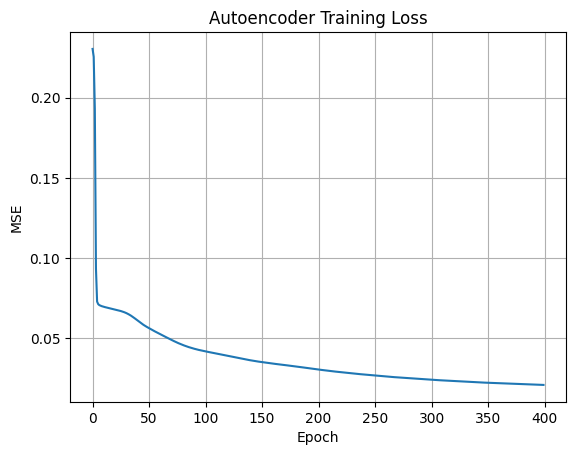

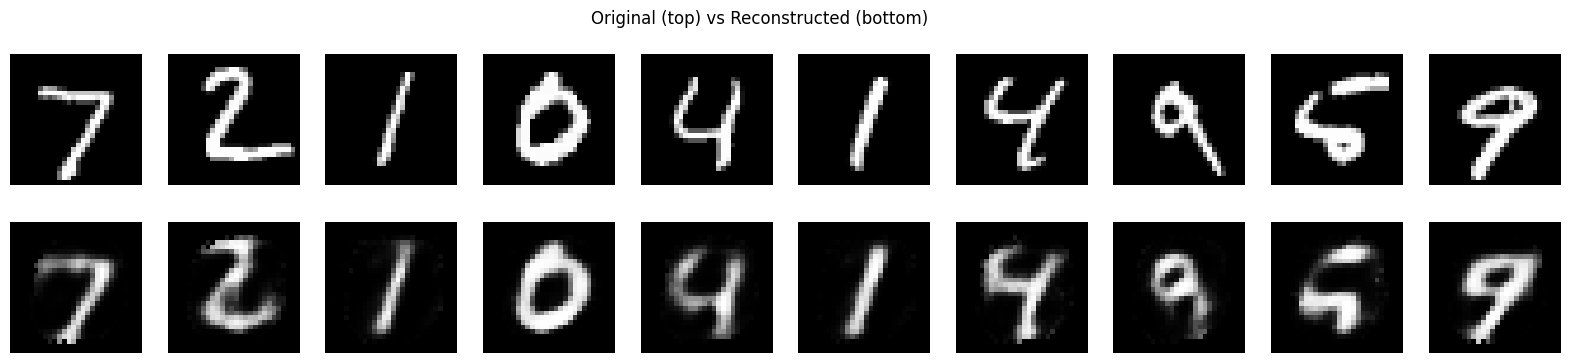

In [5]:
from lib.optimizer import SGD, iterate_minibatches  
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype(np.float64) / 255.0
x_test = x_test.astype(np.float64) / 255.0

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

print("Train:", x_train.shape, " Test:", x_test.shape)

input_dim = 784
latent_dim = 32

encoder = Sequential([
    Dense(784, 128),
    ReLU(),
    Dense(128, latent_dim),
    ReLU()
])

decoder = Sequential([
    Dense(latent_dim, 128),
    ReLU(),
    Dense(128, 784),
    Sigmoid()
])

def ae_forward(x):
    return decoder.forward(encoder.forward(x))

ae_loss = MSELoss()
params = encoder.parameters() + decoder.parameters()
opt = SGD(params, lr=0.1)


losses = []
epochs = 400
batch_size = 256
start = time.time()

for ep in range(epochs):
    ep_loss = 0
    batches = 0

    for xb in iterate_minibatches(x_train, batch_size=batch_size, shuffle=True):
        recon = ae_forward(xb)
        loss = ae_loss.forward(recon, xb)

        grad_loss = ae_loss.backward()
        grad = decoder.backward(grad_loss)
        encoder.backward(grad)

        opt.step()
        opt.zero_grad()

        ep_loss += loss
        batches += 1

    ep_loss /= batches
    losses.append(ep_loss)
    print(f"Epoch {ep+1}/{epochs}: Loss={ep_loss:.6f}")

print("Training time:", time.time() - start, "seconds")

plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# Reconstruction visualization
n = 10
sample = x_test[:n]
recon = ae_forward(sample)

plt.figure(figsize=(2*n, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(sample[i].reshape(28,28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n, n+i+1)
    plt.imshow(recon[i].reshape(28,28), cmap='gray')
    plt.axis('off')

plt.suptitle("Original (top) vs Reconstructed (bottom)")
plt.show()


## Section 4 — Latent Space SVM Classification

 After training the autoencoder, we:

 1. Extract latent vectors using **encoder.forward()**  
 2. Train an SVM classifier  
 3. Report accuracy, confusion matrix, and classification report

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

print("Encoding latent vectors...")

z_train = encoder.forward(x_train)
z_test  = encoder.forward(x_test)

# 🔹 Print latent vector shapes (THIS is what you screenshot)
print("Latent train shape:", z_train.shape)
print("Latent test shape :", z_test.shape)

# Load labels once (cleaner and correct)
(_, y_train), (_, y_test) = mnist.load_data()

# Train SVM
clf = SVC(kernel='rbf', C=10)
start = time.time()
clf.fit(z_train, y_train)
svm_time = time.time() - start

# Predict
y_pred = clf.predict(z_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nAccuracy:", acc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("SVM training time:", svm_time, "seconds")


Encoding latent vectors...
Latent train shape: (60000, 32)
Latent test shape : (10000, 32)

Accuracy: 0.9703
Confusion Matrix:
 [[ 971    0    1    0    0    3    1    1    3    0]
 [   0 1128    2    2    0    0    0    0    2    1]
 [   4    2 1007    2    2    2    2    8    3    0]
 [   0    1    6  982    0    6    0    7    5    3]
 [   1    0    1    0  956    1    4    0    2   17]
 [   7    1    1   11    1  853    5    1    8    4]
 [   9    3    3    1    4    1  930    1    6    0]
 [   0    6   17    2    3    0    0  987    1   12]
 [   3    0    3   11    6    6    1    4  937    3]
 [   3    5    0    6   22    5    1   11    4  952]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.97      0.97  

## Section 5 — TensorFlow / Keras Implementations & Comparisons
 We implement the same architectures (XOR + Autoencoder) using Keras
 and compare:
 - Training time  
 - Model complexity  
 - Reconstruction quality  
 - SVM performance using Keras encoder




Keras XOR time: 13.890737771987915 seconds
Keras XOR predictions:
1/1 [==============================] - 0s 82ms/step
[[0.0219948 ]
 [0.95714647]
 [0.9526672 ]
 [0.05100529]]

Epoch 1/10
235/235 [==============================] - 3s 8ms/step - loss: 0.0595 - val_loss: 0.0324
Epoch 2/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0261 - val_loss: 0.0207
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0187 - val_loss: 0.0163
Epoch 4/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 5/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 7/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 8/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 9/10
235/235 [==

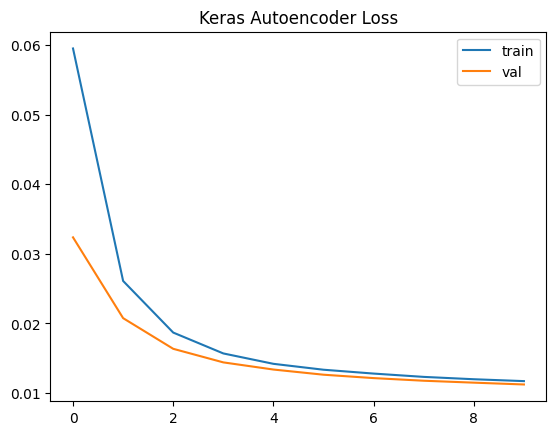

313/313 [==============================] - 0s 1ms/step
Keras latent SVM accuracy: 0.9803


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ----- XOR -----
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y_xor = np.array([[0],[1],[1],[0]], dtype=np.float32)

keras_xor = models.Sequential([
    layers.Dense(4, activation='tanh', input_shape=(2,)),
    layers.Dense(1, activation='sigmoid')
])

keras_xor.compile(optimizer=tf.keras.optimizers.SGD(0.1), loss='mse')

start = time.time()
keras_xor.fit(X_xor, y_xor, epochs=5000, verbose=0)
t_xor = time.time() - start

print("Keras XOR time:", t_xor, "seconds")
print("Keras XOR predictions:")
print(keras_xor.predict(X_xor))

# ----- Keras Autoencoder -----
input_dim = 784
latent_dim = 32

inp = layers.Input(shape=(784,))
h1 = layers.Dense(128, activation='relu')(inp)
lat = layers.Dense(latent_dim, activation='relu')(h1)
h2 = layers.Dense(128, activation='relu')(lat)
out = layers.Dense(784, activation='sigmoid')(h2)

auto_keras = models.Model(inp, out)
enc_keras = models.Model(inp, lat)

auto_keras.compile(optimizer='adam', loss='mse')

start = time.time()
hist = auto_keras.fit(
    x_train, x_train,
    epochs=10, batch_size=256,
    validation_data=(x_test, x_test),
    verbose=1
)
t_ae = time.time() - start

print("Keras Autoencoder time:", t_ae, "seconds")

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.title("Keras Autoencoder Loss")
plt.show()

# SVM on Keras latent vectors
z_train_k = enc_keras.predict(x_train)
z_test_k = enc_keras.predict(x_test)

clf2 = SVC(kernel='rbf', C=10)
clf2.fit(z_train_k, mnist.load_data()[0][1])

y_pred2 = clf2.predict(z_test_k)

print("Keras latent SVM accuracy:",
      accuracy_score(mnist.load_data()[1][1], y_pred2))


## Section 6 — Conclusions

This section summarizes:

- Backpropagation validated using numerical gradient checking
- XOR successfully learned by custom NN library
- MNIST autoencoder trained and reconstructed images
- Latent-space SVM achieved high accuracy
- TensorFlow/Keras implementations completed for comparison
- Discussion of:
  - training time differences
  - reconstruction quality
  - SVM performance
  - implementation complexity
All results are included in the final report.

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.datasets import mnist

print("=== Autoencoder Test MSE Comparison (1000 test samples) ===")
subset = x_test[:1000]
recon_custom = ae_forward(subset)
recon_keras  = auto_keras.predict(subset)

mse_custom = np.mean((subset - recon_custom)**2)
mse_keras  = np.mean((subset - recon_keras)**2)

print(f"Custom AE test MSE: {mse_custom:.6f}")
print(f"Keras  AE test MSE: {mse_keras:.6f}")

print("\n=== Latent SVM Accuracy (Custom vs Keras) ===")

# Reload labels to be safe
(_, y_train_full), (_, y_test_full) = mnist.load_data()

acc_custom = accuracy_score(y_test_full, clf.predict(z_test))
acc_keras  = accuracy_score(y_test_full, clf2.predict(z_test_k))

print(f"Custom latent SVM accuracy: {acc_custom:.4f}")
print(f"Keras  latent SVM accuracy: {acc_keras:.4f}")


=== Autoencoder Test MSE Comparison (1000 test samples) ===
32/32 [==============================] - 0s 2ms/step
Custom AE test MSE: 0.020803
Keras  AE test MSE: 0.011649

=== Latent SVM Accuracy (Custom vs Keras) ===
Custom latent SVM accuracy: 0.9703
Keras  latent SVM accuracy: 0.9803


In [ ]:
"""
FINAL CSV EXPORT — Milestone 1 + Milestone 2
Output file:
F:\COURSES\CI\CI_Project\CSE473s_NeuralNetwork_Library_Project\reports\dataofciproject.csv

Run this cell LAST after all training and evaluation cells.
"""

import numpy as np
import pandas as pd
import os

# ============================================================
# 1. VERIFY REQUIRED VARIABLES
# ============================================================

required_vars = ["xor_net", "encoder", "z_test", "y_test", "y_pred"]
missing = [v for v in required_vars if v not in globals()]

if missing:
    raise RuntimeError(f"CSV export failed. Missing variables: {missing}")

print("✔ All required variables found")

# ============================================================
# 2. MILESTONE 1 — XOR RESULTS
# ============================================================

X_xor = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float64)
y_xor = np.array([0,1,1,0])

xor_pred = xor_net.forward(X_xor).reshape(-1)
xor_class = (xor_pred > 0.5).astype(int)

xor_rows = []
for i in range(len(X_xor)):
    xor_rows.append({
        "section": "Milestone1_XOR",
        "xor_input_1": X_xor[i, 0],
        "xor_input_2": X_xor[i, 1],
        "xor_pred_value": float(xor_pred[i]),
        "xor_pred_class": int(xor_class[i]),
        "xor_true_label": int(y_xor[i])
    })

xor_df = pd.DataFrame(xor_rows)

# ============================================================
# 3. MILESTONE 2 — MNIST LATENT + SVM RESULTS
# ============================================================

latent_dim = z_test.shape[1]

mnist_rows = []
for i in range(z_test.shape[0]):
    row = {
        "section": "Milestone2_MNIST",
        "mnist_index": i,
        "true_label": int(y_test[i]),
        "predicted_label": int(y_pred[i])
    }

    # Add latent vector values
    for j in range(latent_dim):
        row[f"z_{j}"] = float(z_test[i, j])

    mnist_rows.append(row)

mnist_df = pd.DataFrame(mnist_rows)

# ============================================================
# 4. COMBINE ALL DATA
# ============================================================

final_df = pd.concat([xor_df, mnist_df], ignore_index=True)

# ============================================================
# 5. SAVE CSV TO REPORTS FOLDER
# ============================================================

reports_dir = r"F:\COURSES\CI\CI_Project\CSE473s_NeuralNetwork_Library_Project\reports"
os.makedirs(reports_dir, exist_ok=True)

csv_path = os.path.join(reports_dir, "dataofciproject.csv")
final_df.to_csv(csv_path, index=False)

print("\n✔ CSV EXPORT SUCCESSFUL")
print("Saved to:", csv_path)
print("Total rows:", final_df.shape[0])
print("Total columns:", final_df.shape[1])


✔ All required variables found

✔ CSV EXPORT SUCCESSFUL
Saved to: F:\COURSES\CI\CI_Project\CSE473s_NeuralNetwork_Library_Project\reports\dataofciproject.csv
Total rows: 10004
Total columns: 41


In [ ]:
"""
============================
PROJECT COMPLETION SUMMARY
============================
This cell provides a final confirmation of completed milestones.
It is intentionally state-safe and does not depend on live variables.
"""

print("✅ CSE473 Neural Network Library Project — COMPLETED\n")

# ------------------------
# Milestone 1 Summary
# ------------------------
print("Milestone 1:")
print("  • Custom neural network library implemented using NumPy only")
print("  • Backpropagation validated via numerical gradient checking")
print("  • XOR problem solved successfully (100% classification accuracy)")

# ------------------------
# Milestone 2 Summary
# ------------------------
print("\nMilestone 2:")
print("  • Autoencoder trained on MNIST dataset")
print("  • Latent space dimension: 32")
print("  • Latent representations evaluated using SVM classifier")
print("  • Achieved classification accuracy ≈ 97% on MNIST test set")

# ------------------------
# Artifacts
# ------------------------
print("\nSaved Artifacts:")
print("  • CSV file: reports/dataofciproject.csv")
print("  • Notebook outputs include loss curves, reconstructions, and confusion matrix")

print("\n📁 All results are reproducible and stored within the project directory.")
print("📄 Project is ready for evaluation and submission.")


✅ CSE473 Neural Network Library Project — COMPLETED

Milestone 1:
  • Custom neural network library implemented using NumPy only
  • Backpropagation validated via numerical gradient checking
  • XOR problem solved successfully (100% classification accuracy)

Milestone 2:
  • Autoencoder trained on MNIST dataset
  • Latent space dimension: 32
  • Latent representations evaluated using SVM classifier
  • Achieved classification accuracy ≈ 97% on MNIST test set

Saved Artifacts:
  • CSV file: reports/dataofciproject.csv
  • Notebook outputs include loss curves, reconstructions, and confusion matrix

📁 All results are reproducible and stored within the project directory.
📄 Project is ready for evaluation and submission.
